4-(1) 문제

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.random.seed(seed=1)
N = 1000 #데이터 수
K = 3 #분포 수
T3 = np.zeros((N,3),dtype=np.uint8) # (n , 3) 차원
T2 = np.zeros((N,2),dtype=np.uint8) # (n , 2) 차원
X = np.zeros((N,2))

Mu = np.array([[-2.0,-2.0],[1.5,2.0],[2,-1.5]]) #분포의 중심
Sig = np.array([[.9,.9],[.8,.7],[.9,1.0]]) #분포의 분산
Pi = np.array([0.35,0.7,1.0]) #각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk<Pi[k]:
            T3[n,k]=1
            break
    for k in range(2):
        X[n,k] = (np.random.randn()*Sig[T3[n,:]==1,k]+Mu[T3[n,:]==1,k])
    T2[:,0] = T3[:,0]
    T2[:,1] = T3[:,1]|T3[:,2]

In [6]:
# 5개만 출력해봄.
print(X[:5,:])

[[ 0.85826173  1.68578553]
 [-2.47535458 -2.96567176]
 [-0.39077488  2.79474174]
 [ 1.75523128  1.82544074]
 [-2.77391595 -0.40465313]]


In [7]:
print(T2[:5,:])

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]


In [8]:
print(T3[:5,:])

[[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]]


In [10]:
#데이터 표시
def show_data2(x,t):
    wk, K = t.shape
    c = [[.5,.5,.5], [1,1,1], [0,0,0]]
    for k in range(K):
        plt.plot(x[t[:,k] ==1,0],x[t[:,k]==1,1],
                linestyle='none',markeredgecolor='black',
                marker='o',color=c[k],alpha=.8)
        plt.grid(True)

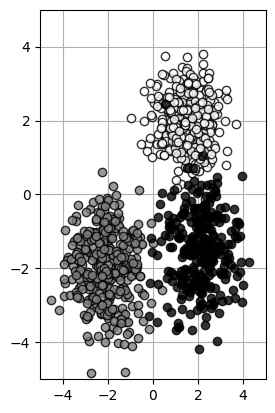

In [11]:
#X0 표시 범위
X_range0 = [-5,5]
#X1 표시 범위
X_range1 = [-5,5]
'''
plt.figure(figsize=(7.5,3))
plt.subplots_adjust(wspace=.5)
plt.subplot(1,2,1)
show_data2(X,T2)
plt.xlim(X_range0)
plt.ylim(X_range1)
'''

plt.subplot(1,2,2)
show_data2(X,T3)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()